# 04. PyTorch Customs Datasets 

We've used some datasets before, but how do you get your own data into PyTorch?

One of the ways is via: custom datasets 

## Domain libraries 

Depending on what you are working with (vision, text, ...) you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.


## 0. Importing PyTorch and setting up device-agnostic code 

In [1]:
import torch 
from torch import nn

# Note: we need PyTorch 1.10.0+ for the course
print(f"PyTorch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available else "cpu"
print(f"Device available: {device}")

PyTorch version: 1.13.1+cu117
Device available: cuda


/home/jvier/PyTorch-Course/pytorch.env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Fri Sep 19 11:18:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              2W /   55W |      11MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data 

Our dataset is a subset of the Food101 dataset

Food101 starts with 101 different classes of food and 1000 images per class (~750 training, ~250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, ~25 testing)

In machine learing it's important to start with a small scale to experiment faster.

In [3]:
import requests 
import zipfile 
from pathlib import Path

# Setup path to a data folder
data_path = Path(".data/")
image_path = data_path/"pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it ...
if image_path.is_dir():
    print(f"'{image_path}' directory alredy exists, skipping this step")
else:
    print(f"'{image_path}' doest not exist, creating one ...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download  
with open(data_path/"pizza_steak_sushi.zip","wb") as f: # This creates also de zipfile 
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak and sushi data ...")
    f.write(request.content)
    
# Unzip data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref: 
    print("Unzipping pizza, steak and sushi data ...")
    zip_ref.extractall(image_path)

'.data/pizza_steak_sushi' directory alredy exists, skipping this step
Unzipping pizza, steak and sushi data ...


## 2. Becoming one with the data (data preparation and exploration)

In [4]:
import os 
def walk_through_dir(dir_path):
    '''Walks through dir_path returning its contents.'''
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '.data/pizza_steak_sushi'
There are 3 directories and 0 images in '.data/pizza_steak_sushi/train'
There are 0 directories and 75 images in '.data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in '.data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in '.data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in '.data/pizza_steak_sushi/test'
There are 0 directories and 19 images in '.data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in '.data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in '.data/pizza_steak_sushi/test/pizza'


### 2.1 Visualizing an image

1. Get all of the images paths
2. Pick a random image path using Pythons's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images let's open the image with Python's PIL
5. We'll then show the image and print metadata 

.data/pizza_steak_sushi/train/sushi/1575445.jpg
sushi
Random image path: .data/pizza_steak_sushi/train/sushi/1575445.jpg
Image class: sushi
Image height: 307
Image width: 512


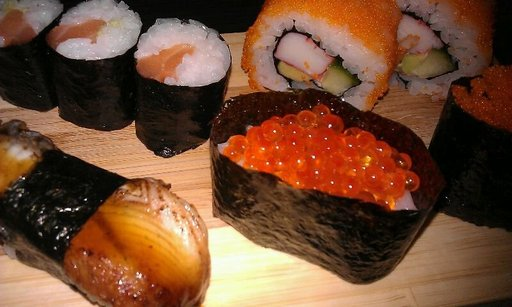

In [6]:
import random 
from PIL import Image

# Set seed if needed
#random.seed(42)

# 1. Get all images paths 
image_path_list = list(image_path.glob("*/*/*.jpg")) # First start for train/test, second for the label and third for the image name

# 2. Pick a random image path 
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name 
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

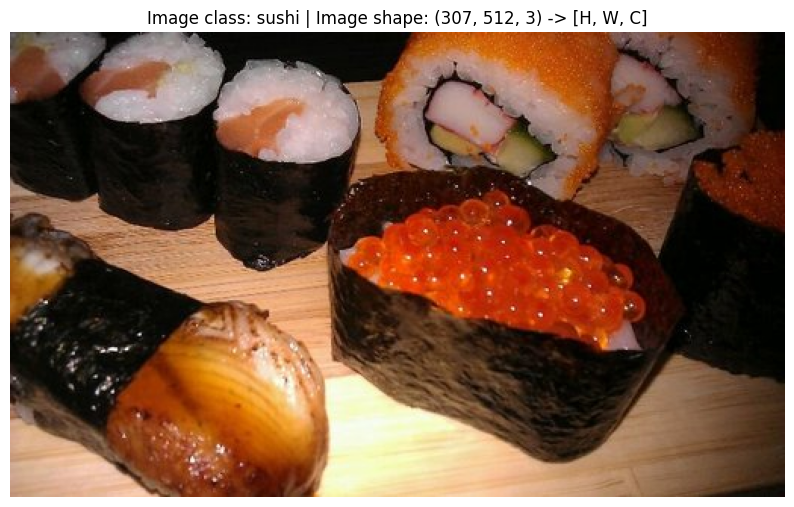

In [7]:
import matplotlib.pyplot as plt 
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [H, W, C]")
plt.axis(False)
plt.show()

# Note: [H, W, C] is the default for matplotlib and pill
# Rembember: for PyTorch the default is [C, H, W]

## 3 Transforming data

Before we can use our image data with PyTorch: 

1. Turn your target data into tensors (numerical representation).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `dataset`and `dataloader`.


In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data wiht `torchvision.transform`

In [9]:
# Write a transform for image 
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizintal to add randomness 
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor 
    transforms.ToTensor()   
]) 
# Note: To do more than 1 transfrom you can use .Compose() or nn.Sequential()

In [10]:
tmp = data_transform(img)
tmp.shape, tmp.dtype

(torch.Size([3, 64, 64]), torch.float32)

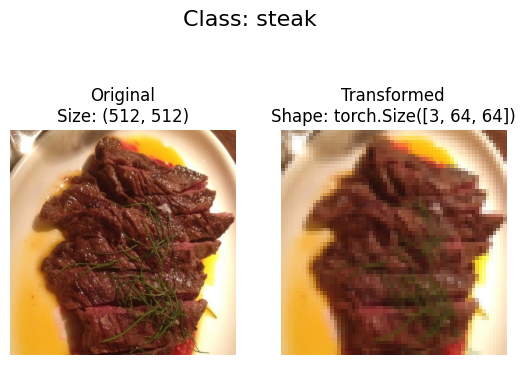

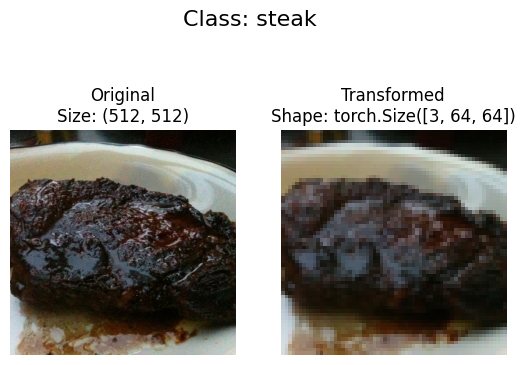

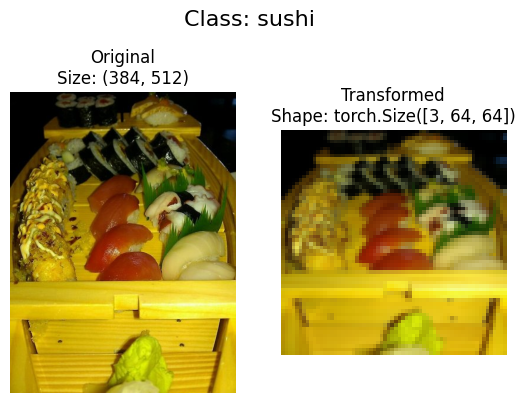

In [11]:
from typing import Optional
def plot_transformed_images(image_paths: list,
                            transform, n: int = 3, 
                            seed: Optional[int] = 42):
    '''
    Selects random images from a path of images and loads/transforms 
    them then plots the original vs the transformed.
    '''
    
    # Set the seed 
    if seed:
        random.seed(42)
    
    # Sample n images paths (one path per img)
    random_image_paths = random.sample(image_paths, k=n)
    
    # Loop for every path 
    for image_path in random_image_paths:
         with Image.open(image_path) as f:
             fig, ax = plt.subplots(nrows = 1, ncols = 2)
             
             # Original image
             ax[0].imshow(f)
             ax[0].set_title(f"Original\nSize: {f.size}")
             ax[0].axis(False)
             
             # Transform and plot target image
             transformed_image = transform(f) # note that we'll need to change shape for matplotlib 
             ax[1].imshow(transformed_image.permute((1,2,0))) # Change shape from CHW (PyTorch) for HWC (matplotlib formate)
             ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
             ax[1].axis(False)
             
             fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
             
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)
             
    

## 4. Option 1: Loading image data using `torchvision.datasets.ImageFolder`

This function works with the saved data format: `root/classX/img.Y`


In [12]:
# Create train_dir and test_dir 
train_dir = image_path/"train"
test_dir = image_path/"test"

In [13]:
# Use ImageFolder to create a dataset 
from torchvision import datasets 
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, # Transform for the data
                                  target_transform=None)    # Transform for the target/label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: .data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: .data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as a list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as a diccionary 
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check lenght of our dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
train_data.samples[0][0]

'.data/pizza_steak_sushi/train/pizza/1008844.jpg'

In [18]:
# Index on the train dataset to get a single image and label 
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> CHW (PyTorch format)
Permuted shape: torch.Size([64, 64, 3]) -> HWC (matplotlib format)


Text(0.5, 1.0, 'Class: pizza')

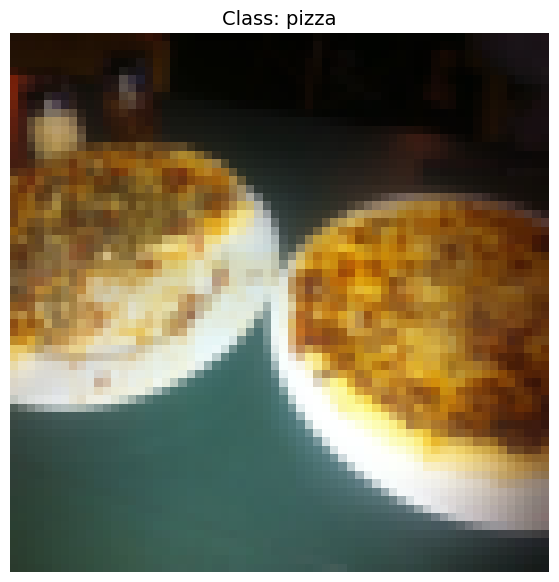

In [19]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out differents shape
print(f"Original shape: {img.shape} -> CHW (PyTorch format)\nPermuted shape: {img_permute.shape} -> HWC (matplotlib format)")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(f"Class: {class_names[label]}", fontsize=14)

### 4.1 Turn loaded images into `DataLoaders`

A `dataloader`is gonna help us to turn our `Datasets` into iterables and we can customize the batch_size so our model can see `batch_size` images at a time.

In [20]:
import os 
n_cores = int(os.cpu_count())
n_cores

16

In [21]:
# Turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(batch_size=BATCH_SIZE,
                              dataset=train_data,
                              num_workers=n_cores,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=n_cores,
                             shuffle=False)

In [22]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
len(train_data), len(test_data)

(225, 75)

In [24]:
225/BATCH_SIZE, 75/BATCH_SIZE   

(225.0, 75.0)

In [25]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like 
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## 5 Option 2: Loading image Data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros: 
* Can create a `Dataset` out of almost anything 
* Not limited to PyTorch pre-built `Datasets` functions 

Cons:
* Even though you could create `Dataset` out of almomst anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writting more code, which could be prone to errors or performance issues

All custom `Datasest` in PyTorch often subclass `torch.utils.data.Datasets`

In [26]:
import os 
import pathlib 
import torch 

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms 
from typing import Tuple, Dict, List, Union, Optional, Sized

In [27]:
# Instace of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names 

We want a function to: 
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class names aren`t found (if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them 

In [28]:
# Setup path for target directory
target_directory = train_dir 
print(f"Target dir: {target_directory}")

# Get class names from target directory 
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: .data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:  
     
    '''
    Finds the class folder names in a target directory
    '''
    
    # 1. Get class names by scaning the target dir
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    # 2. Raise and error if cant be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")  
    
    # 3. Create a dirctionary of idx labels (computers prefere numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [30]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as a transform
3. Create several attributes:
    * path - path of our images
    * transform - transfom function 
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to int labels
4. Create a function to `load_images()`, this will open an image 
5. Overwrite the `__len__()` method to return the lenght of the dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed the index  

In [31]:
# Write custom dataset 
from torch.utils.data import Dataset

# 1. Subclass Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our dataset
    def __init__(self,
                 targ_dir:str,
                 transform=None):
        # 3. Create class atributes 
        # Get all images paths 
        self.paths: list = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform 
        self.transform = transform
        # Create classes 
        self.classes: list
        self.class_to_idx: dict
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    # 4. Create a function to load images
    def load_image(self,
                   index: int) -> Image.Image:
        '''
        Opens an image via a path and returns it.
        '''
        # Get the path of the image using the given index 
        image_path = self.paths[index]
        
        # Using PIL to open the image from the image path
        return Image.open(image_path)
    

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        '''
        Return the number of samples 
        '''
        
        return len(self.paths)
    
    # 6. Overwrite __getitem__()
    def __getitem__(self,
                    index: int) -> Tuple[Union[torch.Tensor, Image.Image], int]:
        '''
        Returns one sample of data, image and label, in a tuple.
        '''
        
        # Get the image
        img = self.load_image(index)
        # Get the class/label
        class_name = self.paths[index].parent.name # expects path in format: "data_folder/class/image.jpg"
        
        # Get class idx
        class_idx = self.class_to_idx[class_name]
        
        # If transform is given
        if self.transform:
            return self.transform(img), class_idx 
        # In other case     
        else:
            return img, class_idx

In [32]:
# Create a transform 
from torchvision import transforms 

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([ # Here no data augmentation needed 
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [33]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=str(train_dir),
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=str(test_dir),
                                     transform=test_transforms)

Original shape: torch.Size([3, 64, 64]) -> CHW (PyTorch format)
Permuted shape: torch.Size([64, 64, 3]) -> HWC (matplotlib format)


Text(0.5, 1.0, 'Class: steak')

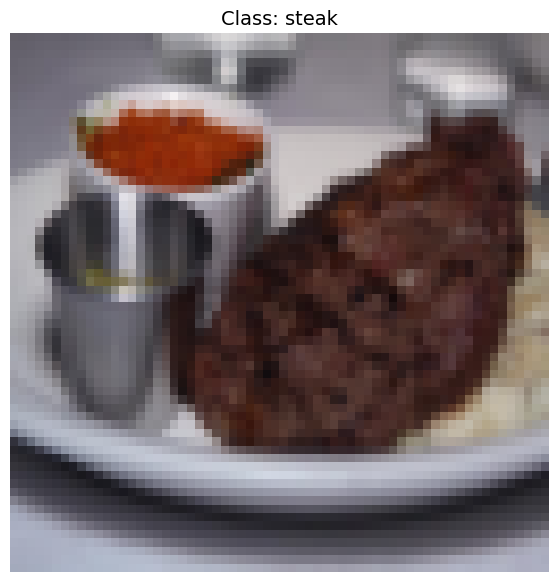

In [34]:
img, label = train_data_custom[0]
img = torch.Tensor(img)

# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out differents shape
print(f"Original shape: {img.shape} -> CHW (PyTorch format)\nPermuted shape: {img_permute.shape} -> HWC (matplotlib format)")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(f"Class: {class_names[label]}", fontsize=14)

In [35]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x781e75147a30>,
 <__main__.ImageFolderCustom at 0x781e75147f40>)

In [36]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [37]:
train_data_custom.classes, train_data_custom.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [38]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

print(train_data_custom.class_to_idx == train_data.class_to_idx)
print(test_data_custom.class_to_idx == test_data.class_to_idx)

True
True
True
True


### 5.3 Create a function to display random images 

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
5. Setup a matplotlib plot. 
4. Get a list of a random sample indexes from the target dataset.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC).


In [39]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: Dataset, 
                          classes: Optional[List[str]] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: Optional[int] = None):
    # 2. Cap n to 10
    if n > 10:
        n = 10
        display_shape = False 
        print(f"For display purposes n shouldn't be larget than 10, setting to 10 and removing shape display.")
    
    # 3. Setup seed
    if seed:
        random.seed(seed)
    
    # 4. Get random sample index
    random_sample_idx = random.sample(range(len(dataset)), k=n)  # type: ignore[arg-type]
    
    # 5. Setup plot
    plt.figure(figsize=(16, 8))
    
    # 6. Loop through random indexes and plot them with matplotlib 
    for i, image_idx in enumerate(random_sample_idx):
        image, label = dataset[image_idx]
        # 7. Adjust tensor dimensions for plotting: CHW (PyTorch) -> HWC (matplotlib)
        image_adjust = image.permute((1, 2, 0))
        
        # Plot 
        cols = n//2
        if n%2 != 0:
            cols += 1
        plt.subplot(2, cols, i+1)
        plt.imshow(image_adjust)
        plt.axis(False)
        
        if classes:
            title = f"Class: {classes[label]}"
            if display_shape:
                title = title + f"\nShape: {tuple(image_adjust.shape)}"
                
        plt.title(title)
        

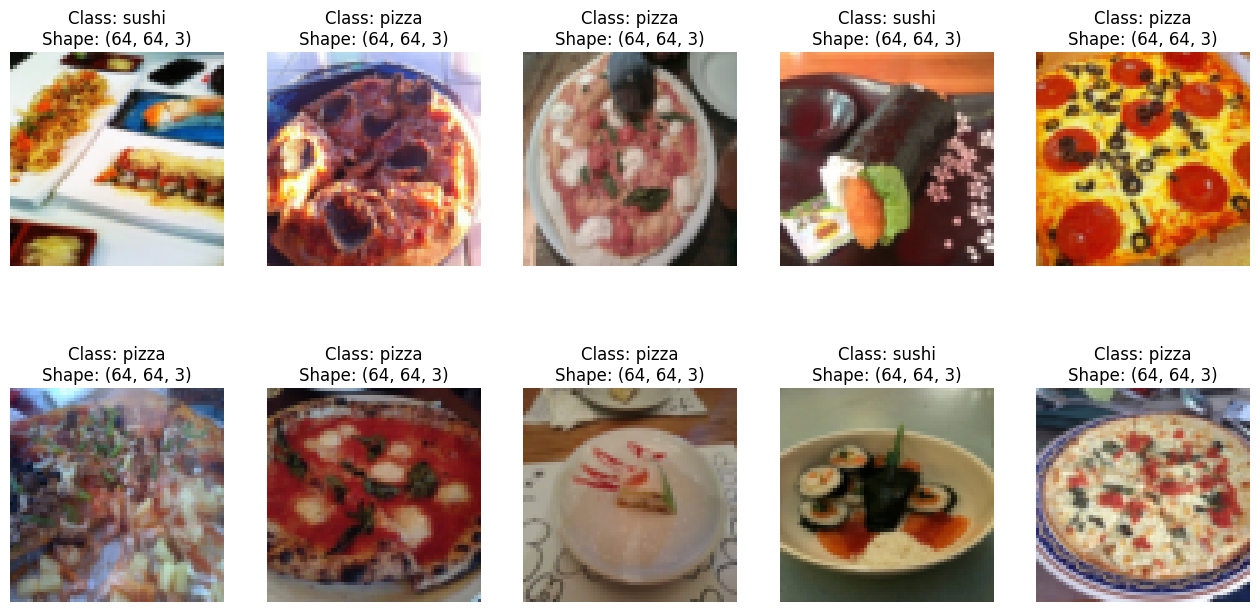

In [40]:
# Display random images from the ImageFolder created Dataset 
display_random_images(dataset=train_data,
                      classes=train_data.classes,
                      n=10,
                      display_shape=True,
                      seed=42)

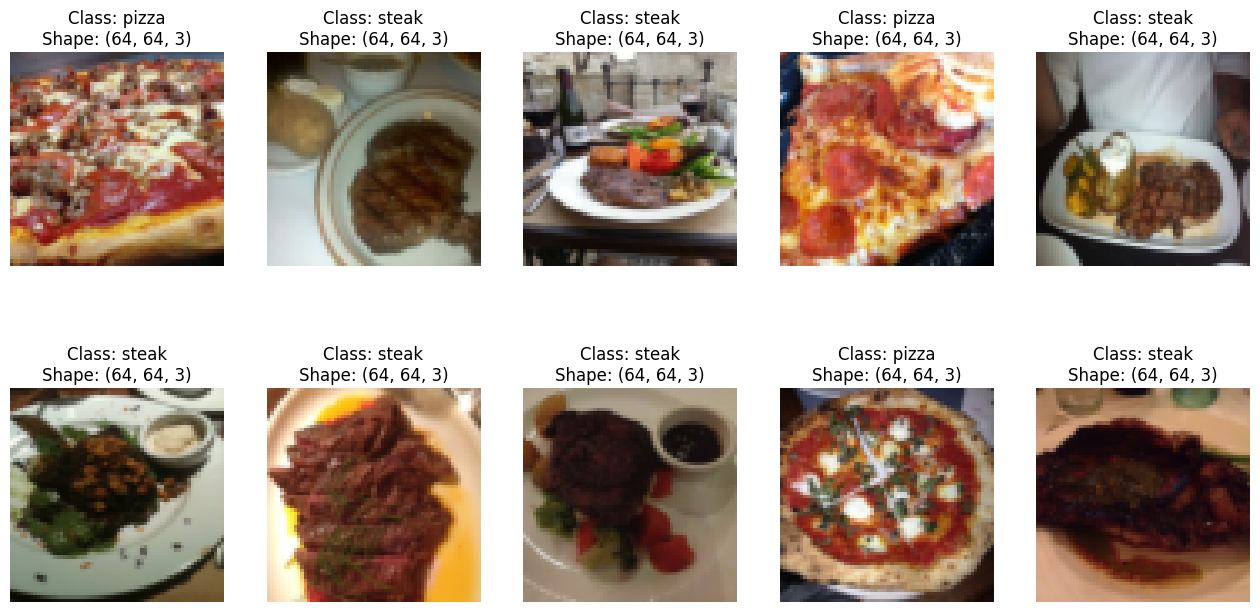

In [41]:
# Display random images from the ImageFolderCustom created by us 
display_random_images(dataset=train_data_custom,
                      classes=train_data.classes,
                      n=10,
                      display_shape=True,
                      seed=42)

### 5.4 Turn custom loaded images into `Dataloader`

In [42]:
type(os.cpu_count())

int

In [43]:
from torch.utils.data import DataLoader
import os 
N_CORES = os.cpu_count()
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=N_CORES) # type: ignore[arg-type]

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=32,
                                    shuffle=False,
                                    num_workers=N_CORES) # type: ignore[arg-type]

In [44]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transfroms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various images transformations to the training images.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [45]:
# Let's look at trivial augment 
from torchvision import transforms 

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=32),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [46]:
image_path

PosixPath('.data/pizza_steak_sushi')

In [47]:
# Get all images path 
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('.data/pizza_steak_sushi/train/steak/1624747.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/922752.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/735441.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/2606444.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/2603058.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/3518960.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/1839481.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/2628106.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/167069.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/2129685.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/1966300.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/1225762.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/3857508.jpg'),
 PosixPath('.data/pizza_steak_sushi/train/steak/2324994.jp

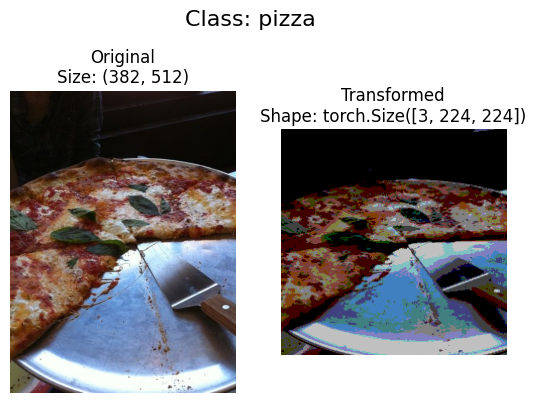

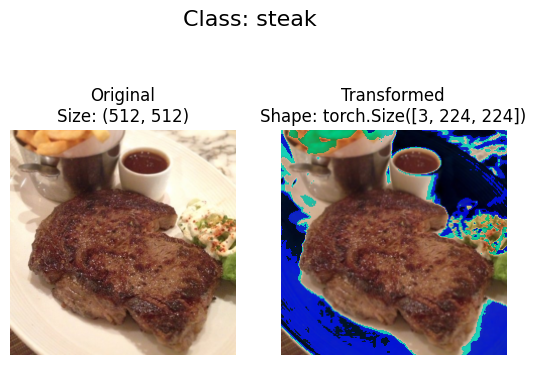

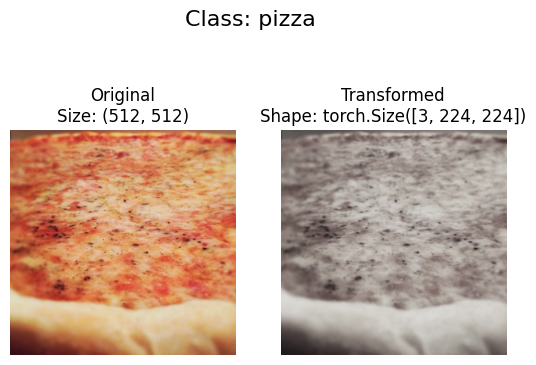

In [48]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        n=3,
                        seed=None,
                        transform=train_transforms)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [49]:
# Create simple transform 
simple_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [50]:
# Getting dataset 
from torchvision import datasets
train_dir = f".data/pizza_steak_sushi/train"
test_dir = f".data/pizza_steak_sushi/test"

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         target_transform=None,
                                         transform=simple_transforms)  


test_data_simple = datasets.ImageFolder(root=test_dir,
                                         target_transform=None,
                                         transform=simple_transforms)  

# Getting dataloaders 
import os 
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     shuffle=True,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS) # type: ignore[arg-type]


test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     shuffle=False,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS) # type: ignore[arg-type]

In [51]:
train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: .data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: .data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [52]:
print(f"Batch size: {BATCH_SIZE}")
print(f"Len of train dataset: {len(train_data_simple)}\nLen of test dataset: {len(test_data_simple)}")
print(f"Len of train dataloader: {len(train_dataloader_simple)}\nLen of test dataloader: {len(test_dataloader_simple)}")

Batch size: 32
Len of train dataset: 225
Len of test dataset: 75
Len of train dataloader: 8
Len of test dataloader: 3


### 7.2 Create a TinyVGG model class

In [53]:
from torch import nn

class TinyVGG(nn.Module):
    '''
    Model architecture copying TinyVGG from CNN Explainer
    '''
    
    def __init__(self, 
                 in_c: int,
                 out_f: int,
                 hidden_units: int,
                 test_mode: bool = False) -> None:
        super().__init__()
        
        self.test_mode = test_mode
        
        # Conv block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_c,
                      out_channels=hidden_units,
                      kernel_size=(3 ,3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2) # Maxpool stride usually the same that MaxPool kernel size 
        )
        
        # Conv block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3 ,3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2) 
        )
        
        # Classifier 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=out_f)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.test_mode:
            print("Shape: ",x.shape)
            x = self.conv_block_1(x)
            print("Shape: ",x.shape)
            x = self.conv_block_2(x)
            print("Shape: ",x.shape)
            x = self.classifier(x)
            print("Shape: ",x.shape)
            return x
        else:
            return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    
    def change_mode(self):
        self.test_mode = not self.test_mode
        print(f"Test mode updated to '{self.test_mode}'")
        

### 7.3 Try a dummy forward pass on a single image (to test the model)

In [54]:
# One forward pass to get the flatten shape 
model_0 = TinyVGG(in_c=3,
              out_f=len(train_data_simple.classes),
              hidden_units=10,
              test_mode=True).to(device)
 
with torch.inference_mode():
    model_0.eval()
    tmp_pred = model_0(train_data_simple[0][0].unsqueeze(dim=0).to(device))
tmp_pred, tuple(tmp_pred.shape)

Shape:  torch.Size([1, 3, 64, 64])
Shape:  torch.Size([1, 10, 30, 30])
Shape:  torch.Size([1, 10, 13, 13])
Shape:  torch.Size([1, 3])


(tensor([[-0.0057, -0.0223,  0.0238]], device='cuda:0'), (1, 3))

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [55]:
from torchinfo import summary 
model_0.change_mode()
summary(model_0,
        input_size=[1, 3, 64, 64])

Test mode updated to 'False'


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loop functions 

* `train_step()` takes in a model and dataloader and trains the model on the dataloader
* `test_step()` same for evaluation 

In [56]:
n_classes = len(class_names)
n_classes

3

In [57]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dev: str) -> List[float]:
    
    # Model in train mode
    model.train()
    
    # Setup train loss and train accuracy values 
    train_loss, train_acc = 0, 0
    
    # Loop through dataloader batches 
    for batch, (X, y) in enumerate(dataloader):        
        # Device
        X, y = X.to(dev), y.to(dev)
        
        # Get logits
        logits = model(X)
        
        # Get loss 
        batch_loss = loss_fn(logits, y)
        train_loss += batch_loss.item()
        
        # Accuracy 
        y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (y_pred==y).sum().item()/len(y_pred) # Manual accuracy compute 
                                                          # Other option: using `from torchmetrics import Accuracy` 
    
        # Zero grad 
        optimizer.zero_grad()
        
        # Backpropagation
        batch_loss.backward()
        
        # Gradient descent 
        optimizer.step()
    # Adjuts metrics
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return [train_acc, train_loss]


def test_step(model: torch.nn.Module,
              dataloader: DataLoader,
              loss_fn: torch.nn.Module,
              dev: str) -> List[float]:
    
    test_loss, test_acc = 0, 0
    
    # Evaluation mode
    with torch.inference_mode():
        model.eval()
        
        # Loop through batches
        for batch, (X, y) in enumerate(dataloader):            
            # Device
            X, y = X.to(dev), y.to(dev)
            
            # Logits & pred
            logits = model(X)
            y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            
            # Loss & accuracy
            batch_loss = loss_fn(logits, y).item()
            test_loss += batch_loss
            test_acc += (y_pred==y).sum().item()/len(y_pred)
        # Adjust metrics
        test_loss /= len(dataloader)
        test_acc /= len(dataloader) 
            
    return [test_acc, test_loss]

In [58]:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [59]:
# Make sure train & test steps works correctly 
tmp = train_step(model=model_0,
           dataloader=train_dataloader_simple,
           optimizer=optimizer,
           loss_fn=loss_fn,
           dev=device)    
print(tmp)
tmp = test_step(model=model_0,
           dataloader=train_dataloader_simple,
           loss_fn=loss_fn,
           dev=device)    
print(tmp)

[0.28125, 1.1003974676132202]
[0.28125, 1.099688783288002]


### 7.6 Creating a `train()` function to combine the train & test steps

In [60]:
def train(model:torch.nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          dev: str = "gpu") -> Dict[str, List[float]]:
    
    # Results dict 
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through epocs 
    for epoch in range(epochs):
        train_acc, train_loss = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           dev=dev)
        
        test_acc, test_loss = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          dev=dev)

        # Print out what's happening 
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    # Return filled results 
    return results 

### 7.7 Train and evaluate model 0

In [61]:
# Seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs 
EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(in_c=3,
                  out_f=len(class_names),
                  hidden_units=10,
                  test_mode=False).to(device)

# Setup loss function & optimizer 
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Start timer 
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        dev=device,
                        epochs=EPOCHS)

end_timer = timer()
print(f"\nTotal training time: {end_timer-start_time:.3f} seconds.")
model_0_results

Epoch: 0 | Train loss: 1.1063 | Train accuracy: 0.3047 | Test loss: 1.0983 | Test accuracy: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train accuracy: 0.3281 | Test loss: 1.0697 | Test accuracy: 0.5417
Epoch: 2 | Train loss: 1.0868 | Train accuracy: 0.4883 | Test loss: 1.0807 | Test accuracy: 0.4924
Epoch: 3 | Train loss: 1.0843 | Train accuracy: 0.3984 | Test loss: 1.0608 | Test accuracy: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train accuracy: 0.4102 | Test loss: 1.0656 | Test accuracy: 0.5644

Total training time: 10.214 seconds.


{'train_loss': [1.1063191592693329,
  1.099805787205696,
  1.0868480801582336,
  1.084263101220131,
  1.0662394315004349],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.41015625],
 'test_loss': [1.0983206828435261,
  1.069687843322754,
  1.08072563012441,
  1.0607999960581462,
  1.0656065940856934],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curve curves of model 0

**Loss curve** is a way of tracking your model's progress over time.

In [62]:
# Get model results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [63]:
def plot_loss_curve(results: Dict[str, List[float]]):
    '''
    Plots training curves of a result dictionary.
    '''
    
    # Get loss values 
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    # Get accuracy values 
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    
    # Get number of epochs used 
    epochs = range(len(results["train_loss"]))
    
    # Setup a plot 
    plt.figure(figsize=(15, 7))
    
    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train accuracy")
    plt.plot(epochs, test_acc, label="Test accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

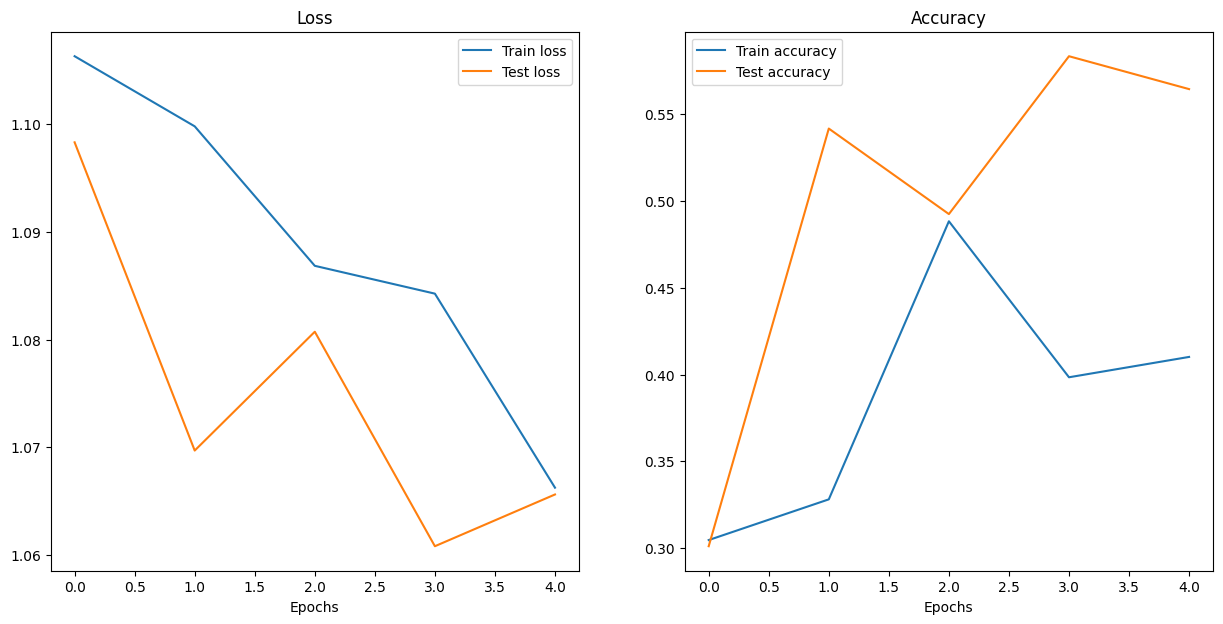

In [64]:
plot_loss_curve(results = model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation 

### 9.1 Create transform with data augmentation 

In [65]:
# Create training transform with TrivilialAugmentation
from torchvision import transforms 

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Datasets`and `Dataloaders` with data augmentation

In [66]:
str(image_path)

'.data/pizza_steak_sushi'

In [67]:
# Turn image foldes into Datasets 
from torchvision import datasets
torch.manual_seed(42)
train_data_augmented = datasets.ImageFolder(root=str(image_path)+"/train",
                                            transform=train_transform_trivial,
                                            target_transform=None)

test_data_simple = datasets.ImageFolder(root=str(image_path)+"/test",
                                            transform=test_transform_simple,
                                            target_transform=None)

In [68]:
len(train_data_augmented), len(test_data_simple)

(225, 75)

In [69]:
# Turn our data into dataloaders
import os 
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) 

In [70]:
len(train_dataloader_augmented), len(test_dataloader_simple)

(8, 3)

### 9.3 Construct and train model 1

In [71]:
from timeit import default_timer as timer 

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create model 1 
model_1 = TinyVGG(in_c=3,
                  hidden_units=10,
                  out_f=n_classes,
                  test_mode=False).to(device)

# Loss & optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)

# Epochs 
NUM_EPOCHS = 5

# Timer 
start_t = timer()

# Train
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        dev=device)
      
# End timer 
end_t = timer()
print(f"Total training time for model_1: {end_t-start_t:.3f} seconds")

Epoch: 0 | Train loss: 1.1069 | Train accuracy: 0.3047 | Test loss: 1.0996 | Test accuracy: 0.2292
Epoch: 1 | Train loss: 1.0987 | Train accuracy: 0.3125 | Test loss: 1.0716 | Test accuracy: 0.5417
Epoch: 2 | Train loss: 1.0894 | Train accuracy: 0.4180 | Test loss: 1.0777 | Test accuracy: 0.6042
Epoch: 3 | Train loss: 1.0983 | Train accuracy: 0.3164 | Test loss: 1.0647 | Test accuracy: 0.6042
Epoch: 4 | Train loss: 1.0913 | Train accuracy: 0.3477 | Test loss: 1.0844 | Test accuracy: 0.4223
Total training time for model_1: 10.349 seconds


In [72]:
model_1_results

{'train_loss': [1.1068512946367264,
  1.0986667722463608,
  1.0894185602664948,
  1.098342940211296,
  1.0912812799215317],
 'train_acc': [0.3046875, 0.3125, 0.41796875, 0.31640625, 0.34765625],
 'test_loss': [1.0995779434839885,
  1.0715981324513753,
  1.0776751041412354,
  1.064679503440857,
  1.0843542416890461],
 'test_acc': [0.22916666666666666,
  0.5416666666666666,
  0.6041666666666666,
  0.6041666666666666,
  0.42234848484848486]}

### 9.4 Plot loss curves 

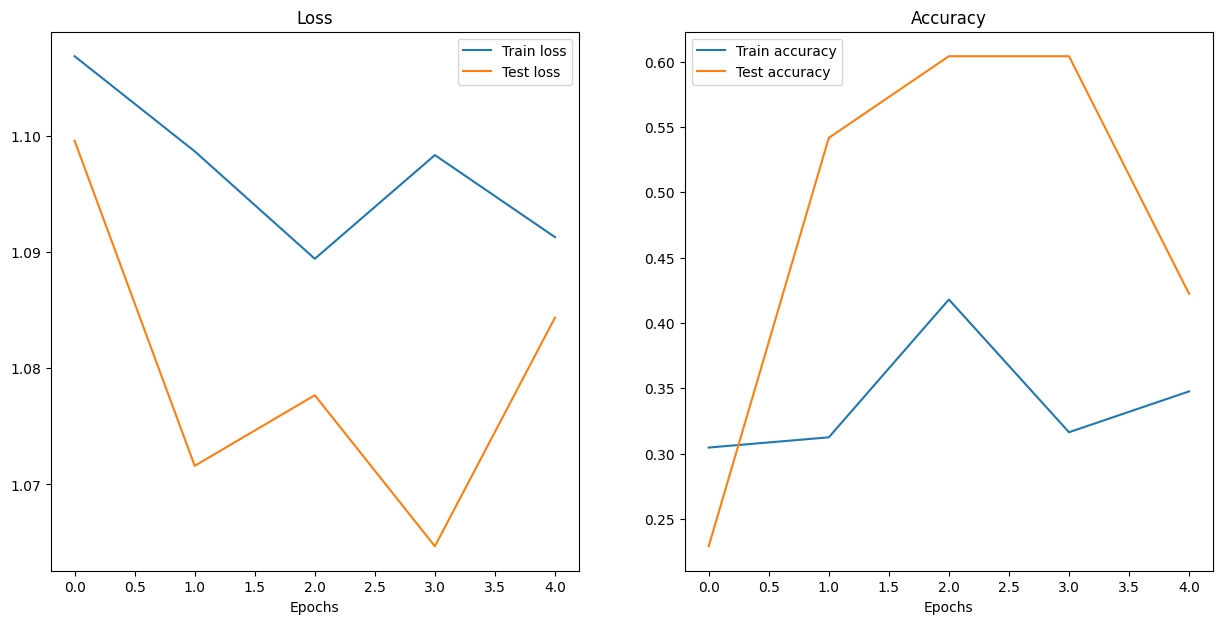

In [73]:
plot_loss_curve(results=model_1_results)

## 10. Compare model results 

There are different ways:
1. Hard coding (what we're doing)
2. Using PyTorch + Tensorboard 
3. Weights & biases 
4. MLFlow

In [74]:
import pandas as pd 
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069688,0.541667
2,1.086848,0.488281,1.080726,0.492424
3,1.084263,0.398438,1.060800,0.583333
4,1.066239,0.410156,1.065607,0.564394


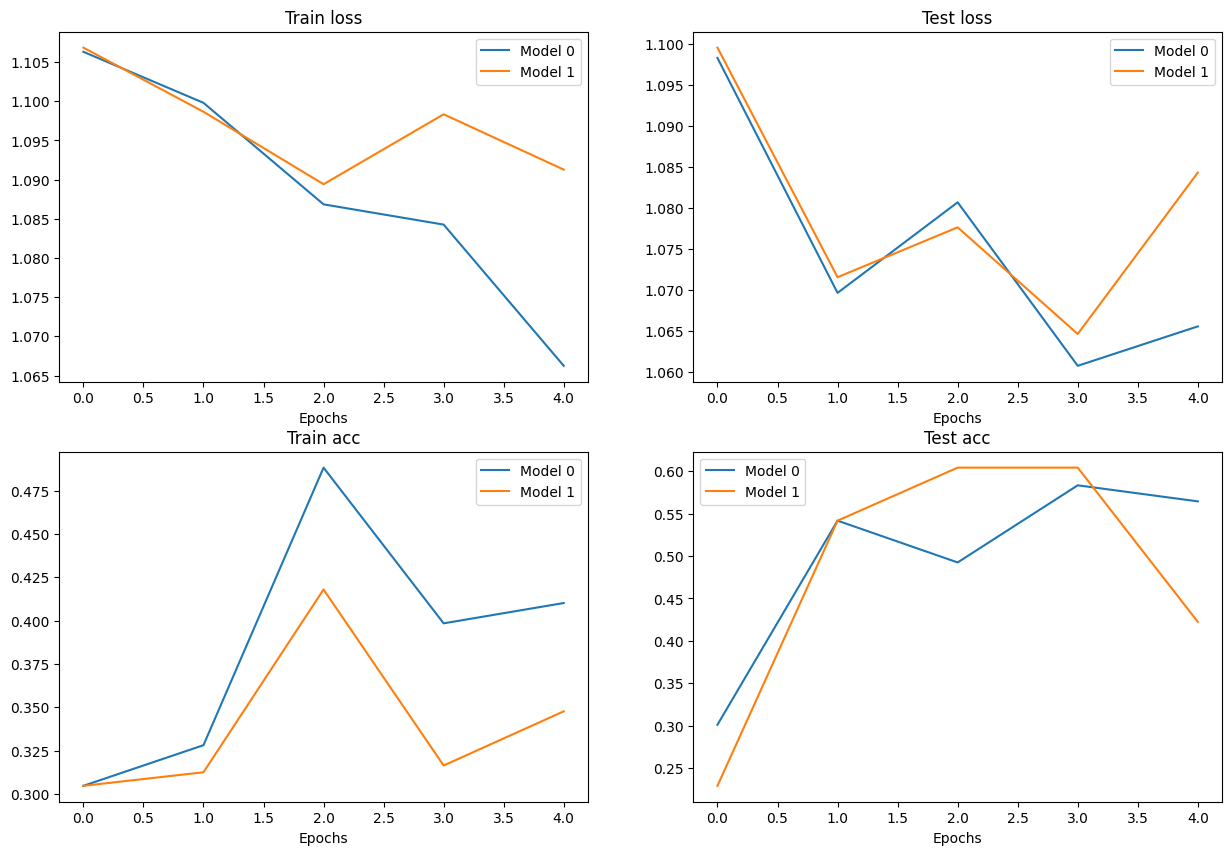

In [75]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get numb epochs 
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs,
         model_0_df["train_loss"],
         label = "Model 0")
plt.plot(epochs,
         model_1_df["train_loss"],
         label = "Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs,
         model_0_df["test_loss"],
         label = "Model 0")
plt.plot(epochs,
         model_1_df["test_loss"],
         label = "Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs,
         model_0_df["train_acc"],
         label = "Model 0")
plt.plot(epochs,
         model_1_df["train_acc"],
         label = "Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs,
         model_0_df["test_acc"],
         label = "Model 0")
plt.plot(epochs,
         model_1_df["test_acc"],
         label = "Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()
plt.show()



## 11. Making a prediction on a custom image

How do you make a prediction on a sample that's not either training or testing dataset.

In [76]:
# Download custom image 
import requests

# Setup image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"f{custom_image_path} already exists, skipping download...")

f.data/04-pizza-dad.jpeg already exists, skipping download...


### 11.1 Loading in a custom image with PyTorch

* **Important**: custom image must be in the same format as the data our model was trained on.
    1. Size must be (64, 64, 3)
    2. Dtype must be `torch.float32`
    3. On right device


In [77]:
import torchvision

custom_imagen_uint8 = torchvision.io.read_image(path=str(custom_image_path))
print(f"Custom image tensor:\n{custom_imagen_uint8}")
print(f"Custom image shape: {custom_imagen_uint8.shape}")
print(f"Custom image dtype: {custom_imagen_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype

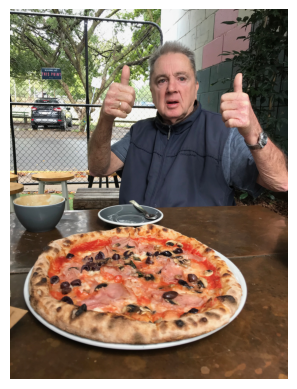

In [78]:
plt.imshow(custom_imagen_uint8.permute(1, 2, 0))
plt.axis(False)
plt.show()

## 11.2 Making a prediction on a custom image with a trained PyTorch model

In [160]:
# Try to do a prediction in uint8 format 
if False:
    with torch.inference_mode():
        model_1.eval()
        model_1(custom_imagen_uint8)

In [85]:
# Load in the custom image and conver it into torch.float32
custom_image = torchvision.io.read_image(path=str(custom_image_path)).type(dtype=torch.float32) / 255 # Type changed & scaled to (0, 1) range
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

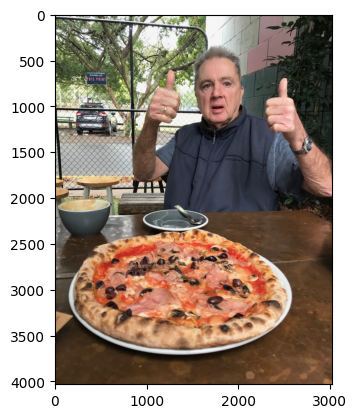

In [89]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.show()

In [ ]:
# Create transform compose to resize 
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform image
custom_image_transformed = custom_image_transform(custom_image)

# Print out shapes
print(f"Original: {custom_image.shape}\nTransformed: {custom_image_transformed.shape}")

Original: torch.Size([3, 4032, 3024])
Transformed: torch.Size([3, 64, 64])


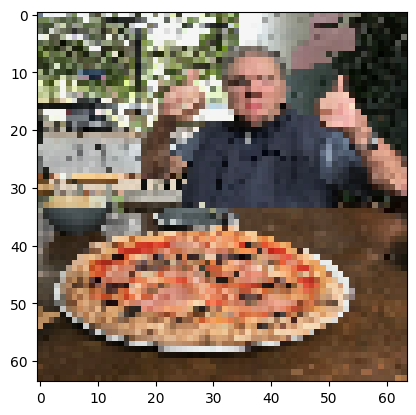

In [92]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.show()

In [99]:
with torch.inference_mode():
        model_1.eval()
        custom_image_logits = model_1(custom_image_transformed.unsqueeze(dim=0).to(device)) # Right device 
custom_image_logits.shape, custom_image_logits

(torch.Size([1, 3]), tensor([[-0.1483,  0.0238, -0.0393]], device='cuda:0'))

Note: to make the prediction we had to:
1. Load the image and turn it into a tensor
2. Make sure the image was the same datatype as the model (`torch.float32`)
3. Make sure the image was the same shape as the data the model trained with (1, 3, 64, 64) -> BatchCHW.

In [ ]:
# Convert logits into predictions probabilities 
custom_image_probs = torch.softmax(custom_image_logits, dim=1)
custom_image_probs

tensor([[0.3028, 0.3596, 0.3376]], device='cuda:0')

In [106]:
# Convert probs into labels 
custom_image_labels = torch.argmax(custom_image_probs, dim=1).cpu()
custom_image_labels

tensor([1])

In [108]:
class_names[custom_image_labels.item()] # In this case we got a wrong prediction 

'steak'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:
A function where we pass an image path and our model make the prediction on that image and plot image + prediction.

In [ ]:
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        real_label: int,
                        class_names: list) -> torch.Tensor:
    
    '''
    Make prediction on the given image by path and plot the image with the inferenced label.
    Args:
        Model: Model to predict
        Image_path: Path where image it is 
        Real_label: Real label of image
        Class names: List of the classes indexed by the labels
    '''
    
    # Get the image and:
    # 1. Adjust dtype
    # 2. Adjust device
    # 3. Adjust scale
    # 4. Add batch dimension
    image = torchvision.io.read_image(path=image_path).type(dtype=torch.float32).to(device) / 255
    
    # Create a `transform.Compose()` to resize
    transform_compose = transforms.Compose([
        transforms.Resize(size=(64, 64))
    ]) 
    image = transform_compose(image) 
    
    with torch.inference_mode():
        model.eval()
        
        # Logits, probs & label
        logits = model(image.unsqueeze(dim=0))
        probs = torch.softmax(logits, dim=1)
        labels = torch.argmax(probs, dim=1)        
    
    # Plot image and prediction 
    plt.figure(figsize=(10, 7))
    plt.imshow(image.permute(1, 2, 0).cpu())
    plt.axis(False)
    title = f"Prediction: {class_names[int(labels.item())]} | with prob: {probs[0][int(labels.item())]:.2f}"
    if real_label == labels.item():
        plt.title(title, c="g")
    else:
        plt.title(title, c="r")
    plt.show()
    
    return labels

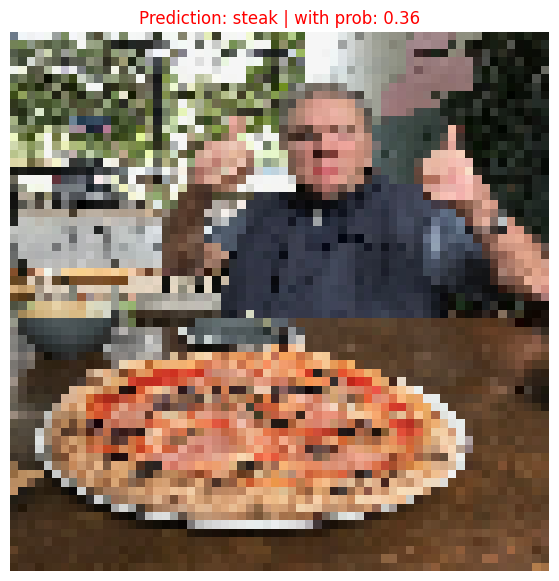

In [159]:
prediction = pred_and_plot_image(model=model_1,
                    image_path=str(custom_image_path),
                    real_label=class_dict["pizza"],
                    class_names=class_names)